### Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import util as ut # custom import

### Create Data Frame

In [2]:
_df_t1 = pd.read_csv('dataset/Task1-A1-Dataset.csv')

C:\Users\GGPC\AppData\Local\Temp\ipykernel_43424\3073044916.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  _df_t1 = pd.read_csv('dataset/Task1-A1-Dataset.csv')


this is throwing error DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
Lets see what is wrong with column 19

In [3]:
_col_data = _df_t1.iloc[:,19]
_col_data.apply(type).value_counts()

song_name
<class 'str'>      21519
<class 'float'>    20786
Name: count, dtype: int64

song_name is the name of the column 19. It should only contain type string but contains float.
In pandas NaN is represented as type float. 
Let's check if this is causing the issue.

In [4]:
_col_data.isna().sum()  # This should return the count of NaN values in the column



np.int64(20786)

float count 20786 = missing value count
With this we can verify that the error is being caused by the NaN in Song Name Column

### Explore and Visualize the Data Frame


Let's check out the info of the DF

In [5]:
_df_t1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42305 entries, 0 to 42304
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      42305 non-null  float64
 1   energy            42305 non-null  float64
 2   key               42305 non-null  int64  
 3   loudness          42305 non-null  float64
 4   mode              42305 non-null  int64  
 5   speechiness       42305 non-null  float64
 6   acousticness      42305 non-null  float64
 7   instrumentalness  42305 non-null  float64
 8   liveness          42305 non-null  float64
 9   valence           42305 non-null  float64
 10  tempo             42305 non-null  float64
 11  features          42305 non-null  object 
 12  id                42305 non-null  object 
 13  uri               42305 non-null  object 
 14  track_href        42305 non-null  object 
 15  analysis_url      42305 non-null  object 
 16  duration_ms       42305 non-null  int64 

Let's drop unwanted columns such as id,uri,track_href,analysis_url,unnamed:0 and Visualize the results

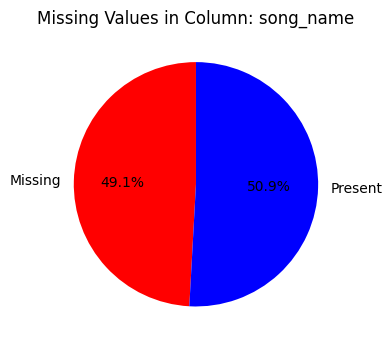

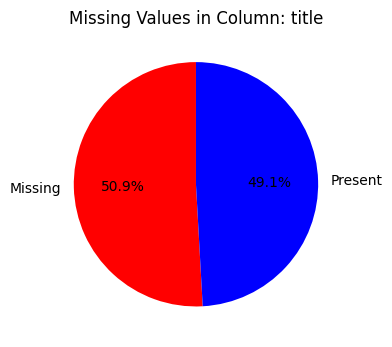

['song_name', 'title']


In [6]:
data_analyzer = ut.DataframeAnalyzer(_df_t1)
data_analyzer.drop_features(['id','uri','track_href','analysis_url','Unnamed: 0'])
missing_value_columns = data_analyzer.visualize_and_return_missing_values_per_column(size=(4,4), missing_threshold=0.4)
print(missing_value_columns)

We can see that 2 columns have half of the values missing.
Lets remove these features and try to visualize the data


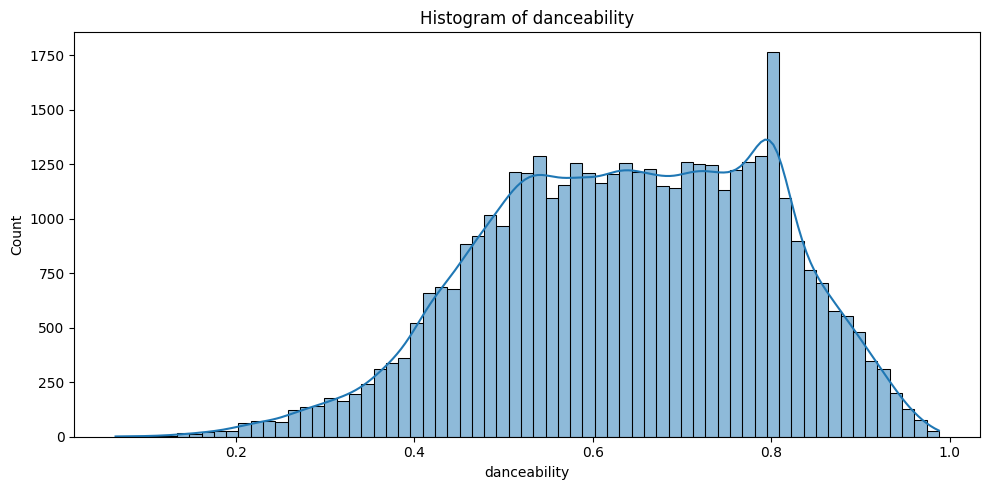

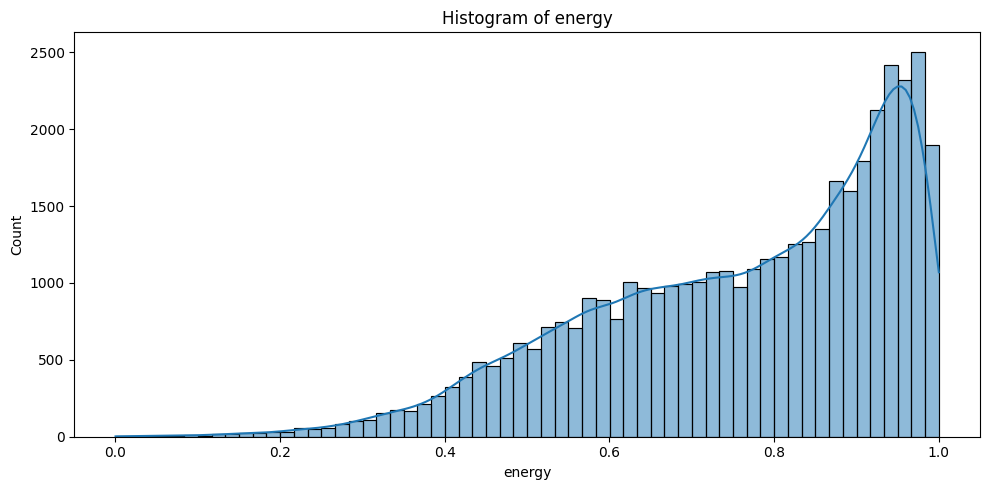

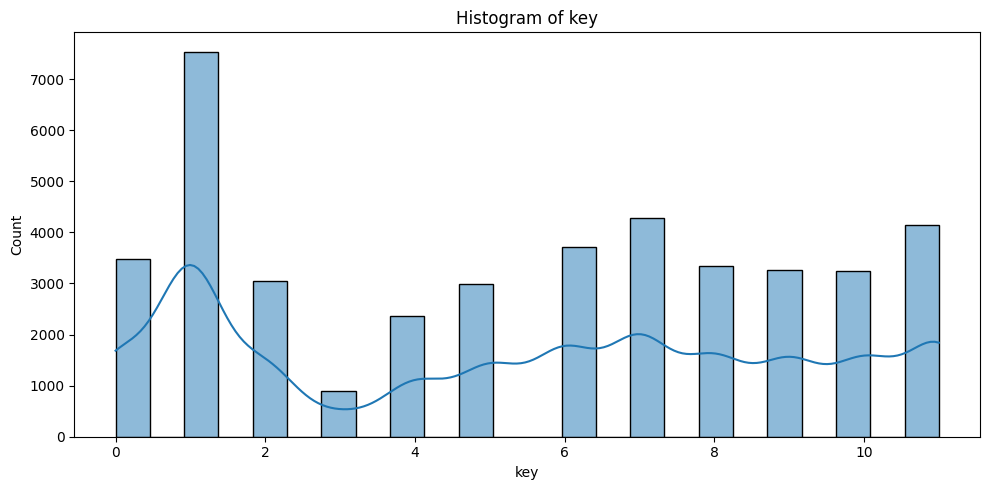

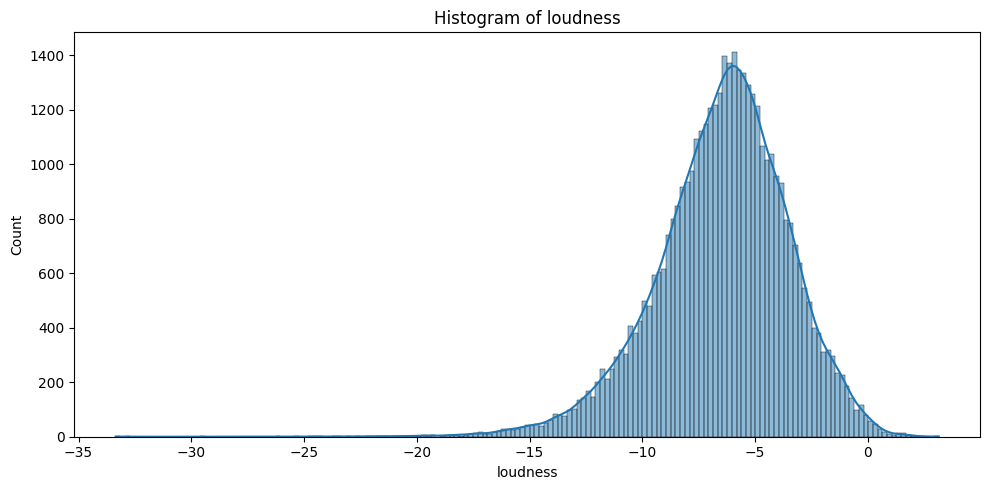

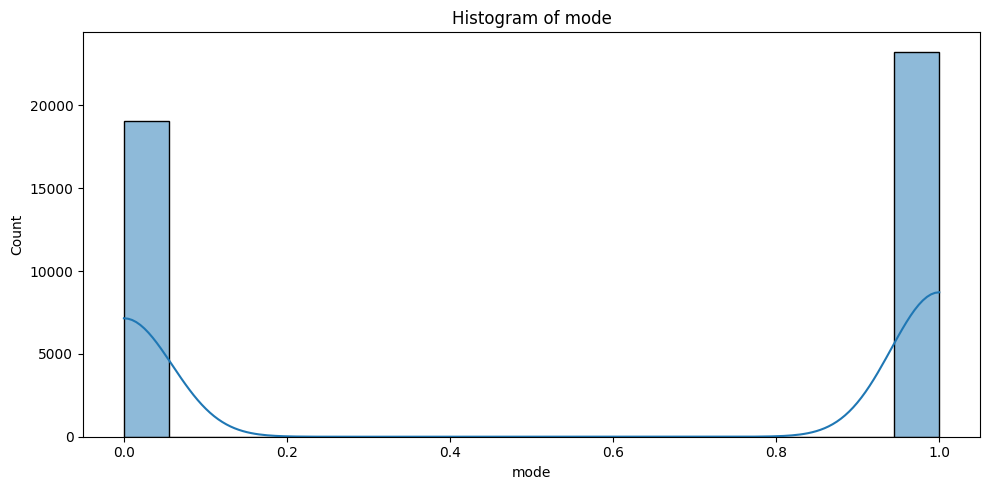

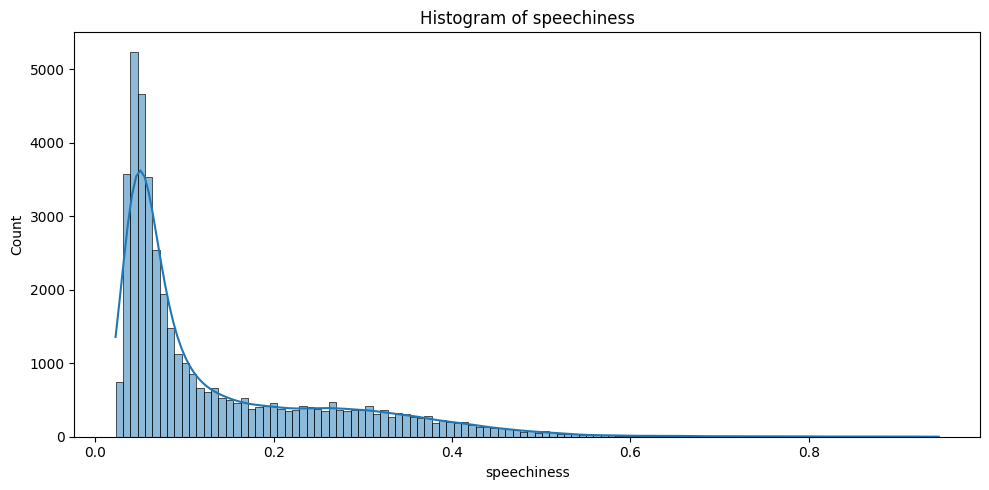

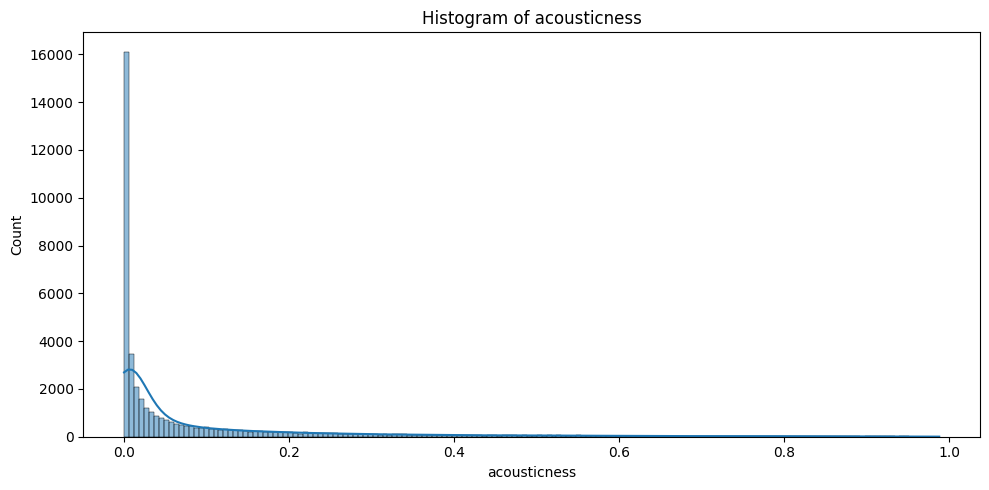

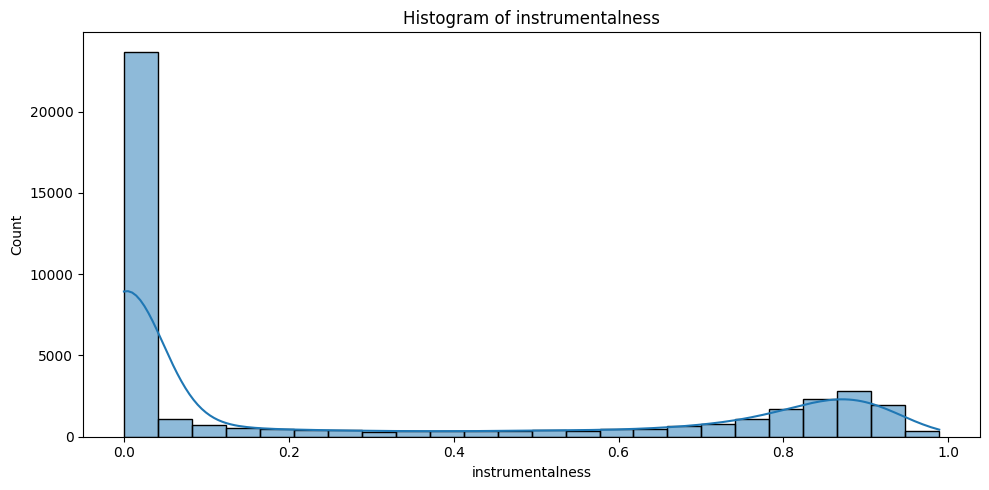

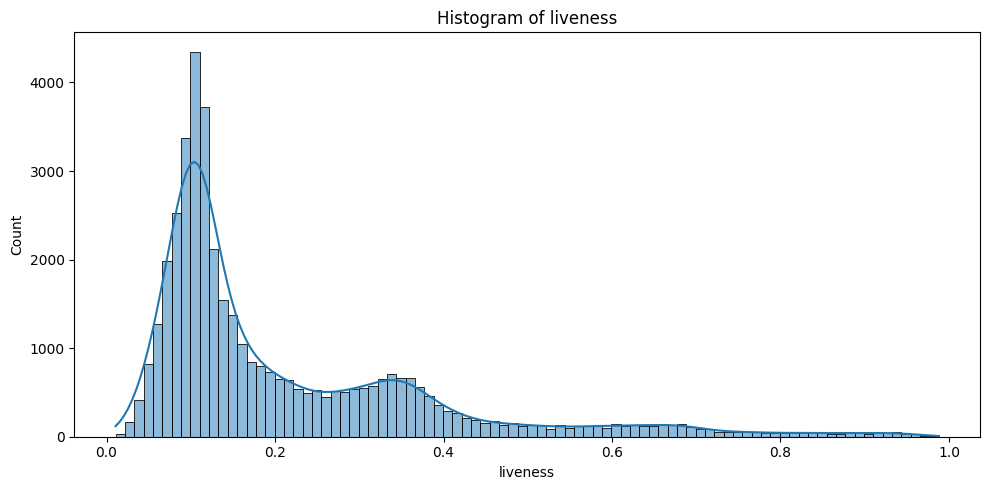

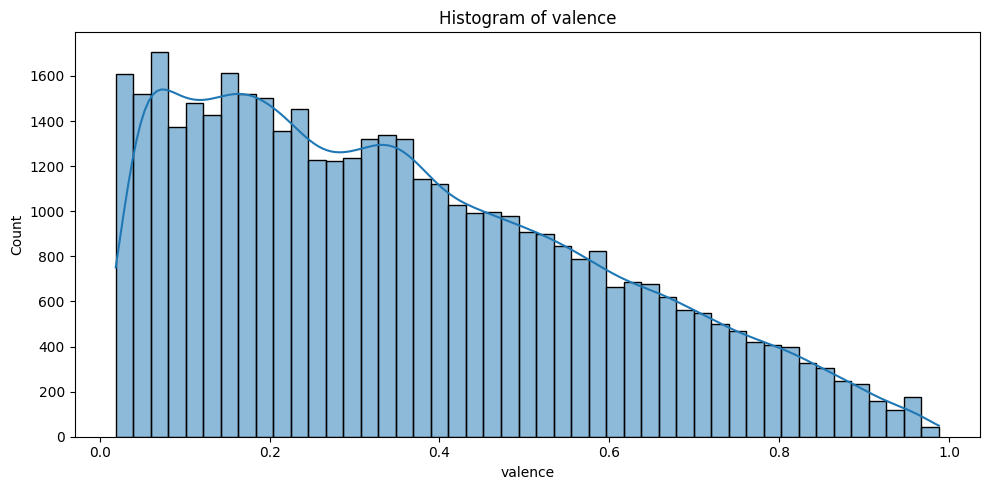

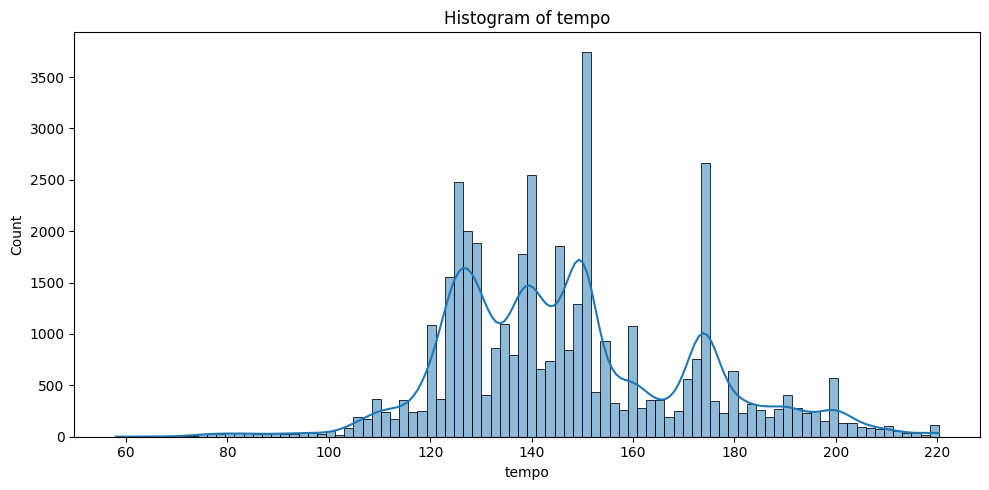

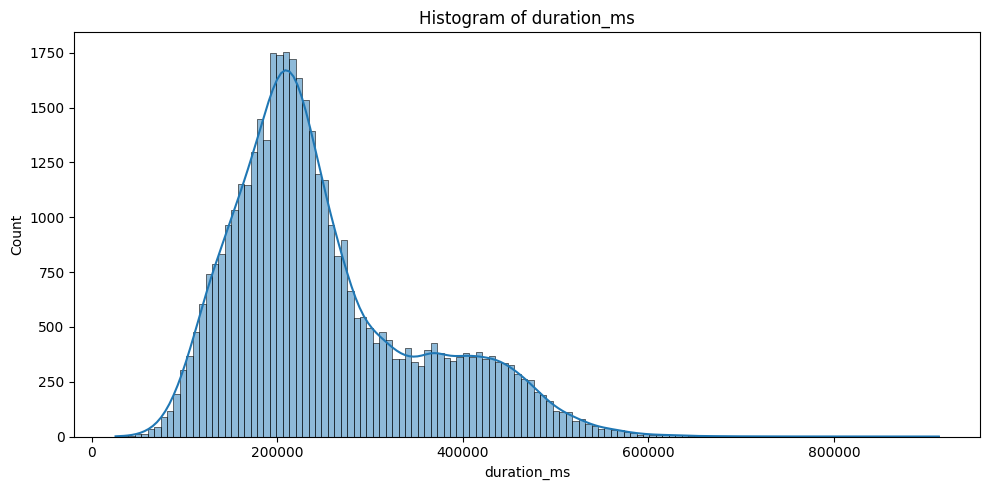

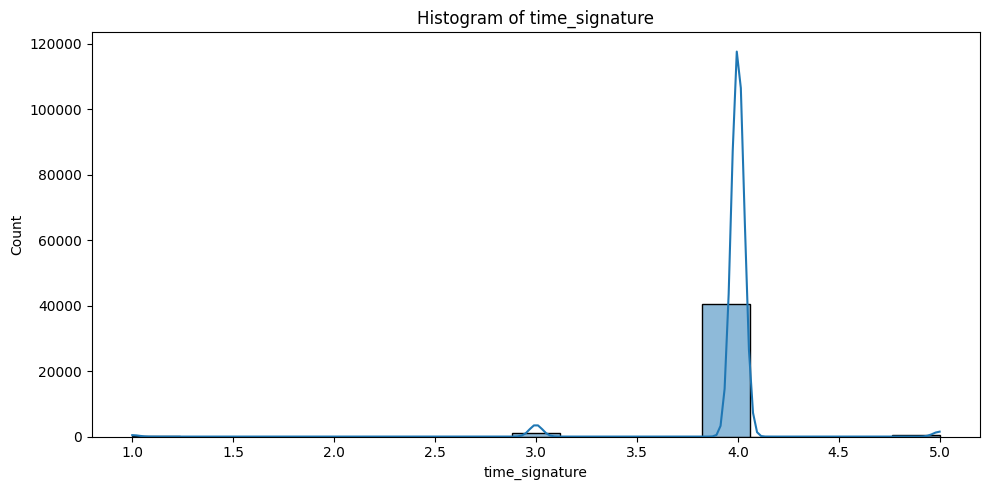

In [7]:
data_analyzer.drop_features(missing_value_columns)
data_analyzer.visualize_numeric_columns(type="histo", unique_value_threshhold=0)

It looks like time_signature is majority 4 therefore it is safe to drop as it won't be helpful identifying genres

Seems almost all the data is skewed.
Let's see if this has anything to do with genre.

In [8]:
data_analyzer.drop_features(["time_signature"])
skew = data_analyzer.get_skewed()
print(skew)

danceability       -0.265484
energy             -0.738103
key                -0.001146
loudness           -0.645511
mode               -0.198831
speechiness         1.673151
acousticness        2.534878
instrumentalness    0.752695
liveness            1.782580
valence             0.549453
tempo               0.478337
duration_ms         0.951910
dtype: float64


We can see that few of the features are left skewed. Energy and loudness show above 0.5 but rest is pretty close to 0.
Loudness looks roughly symmetric therefore logtransform won't help as much
We will not be log transforming these as log transforming these will cause more distortion.

we will perform power transform on these columns below

speechiness, acousticness, instrumentalness,liveness,duration_ms, energy,valence

In [9]:
data_analyzer.power_transform(['speechiness', 'acousticness', 'instrumentalness', 'liveness', 'duration_ms','energy','valence'], method='yeo-johnson')

print(data_analyzer.get_skewed())

danceability       -0.265484
energy             -0.197220
key                -0.001146
loudness           -0.645511
mode               -0.198831
speechiness         0.470758
acousticness        0.776197
instrumentalness    0.516382
liveness            0.333949
valence             0.056226
tempo               0.478337
duration_ms         0.000154
dtype: float64


lets visualize the effect

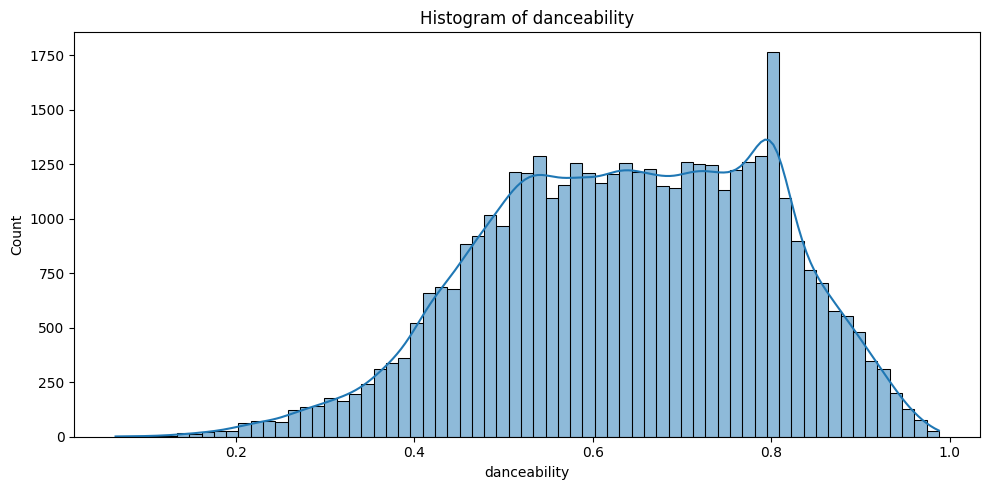

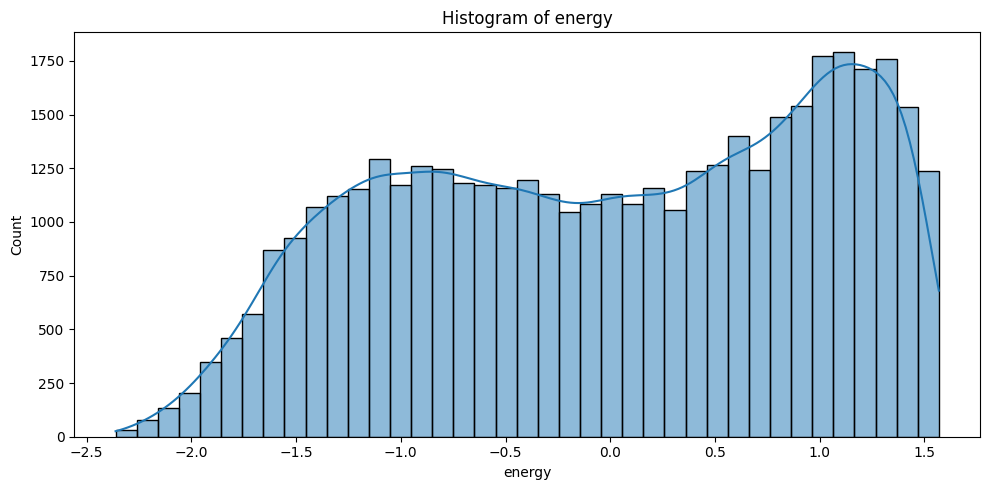

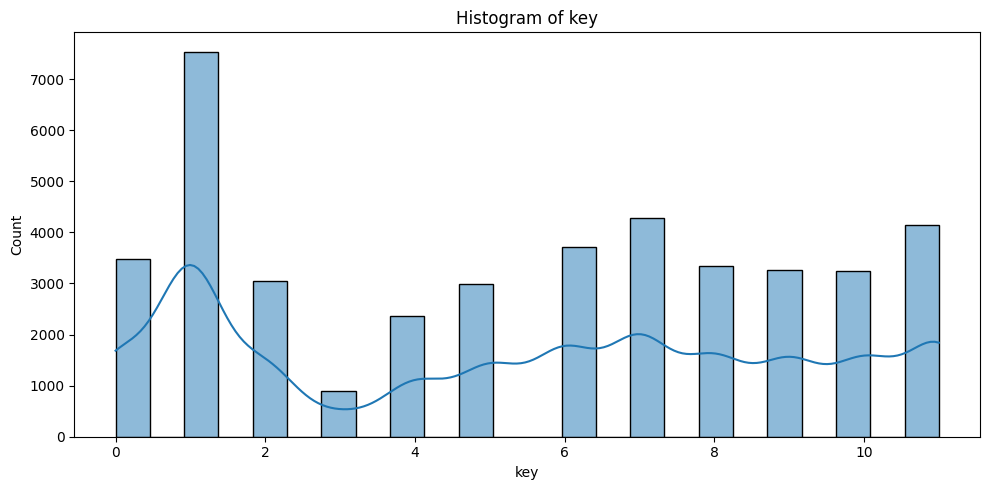

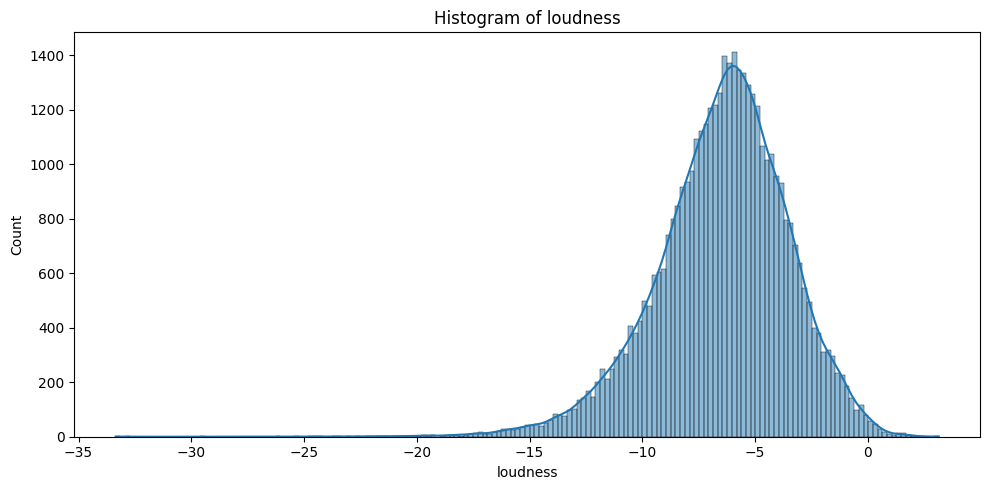

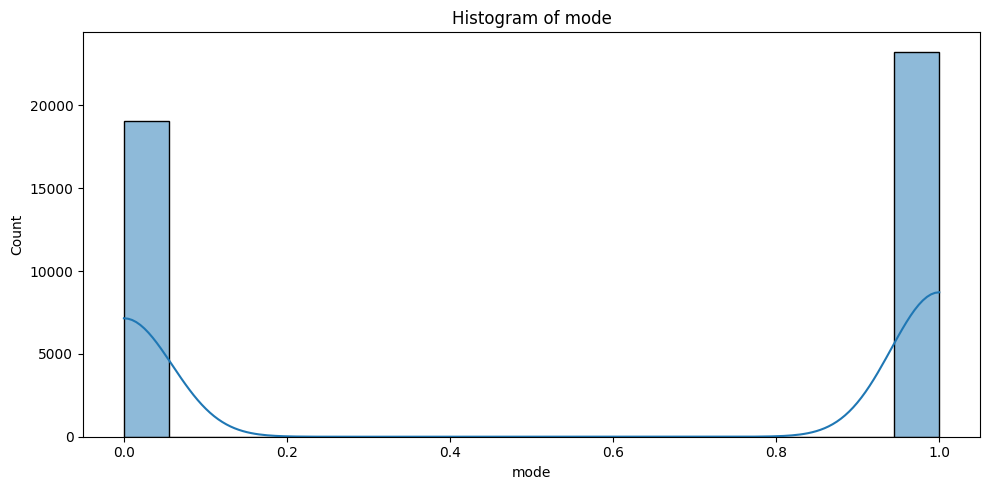

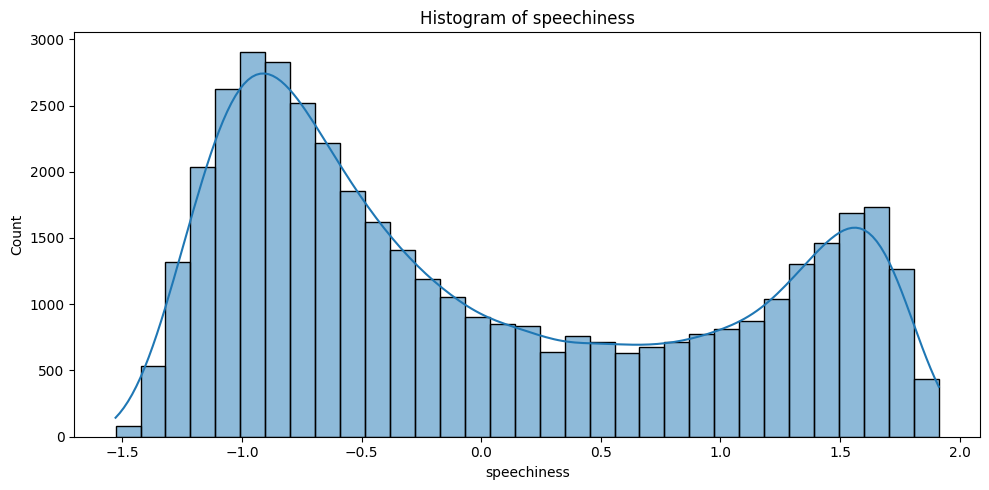

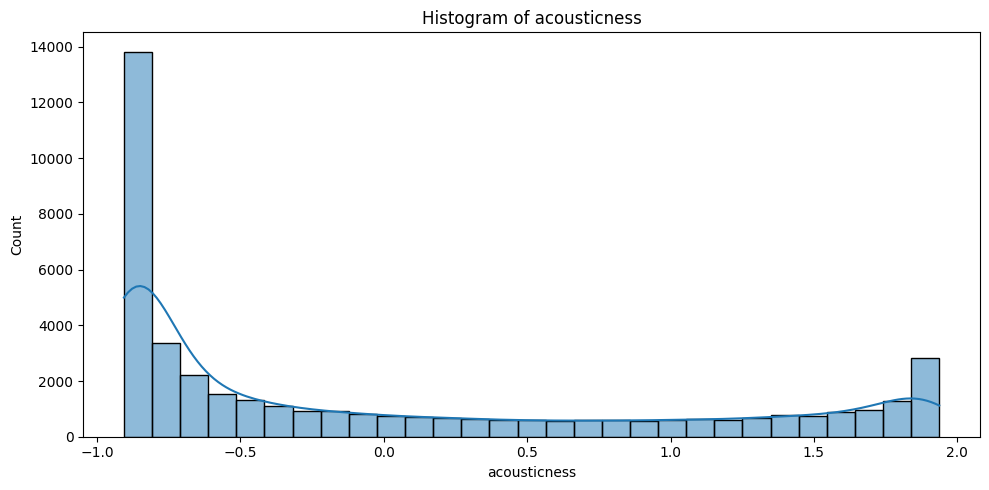

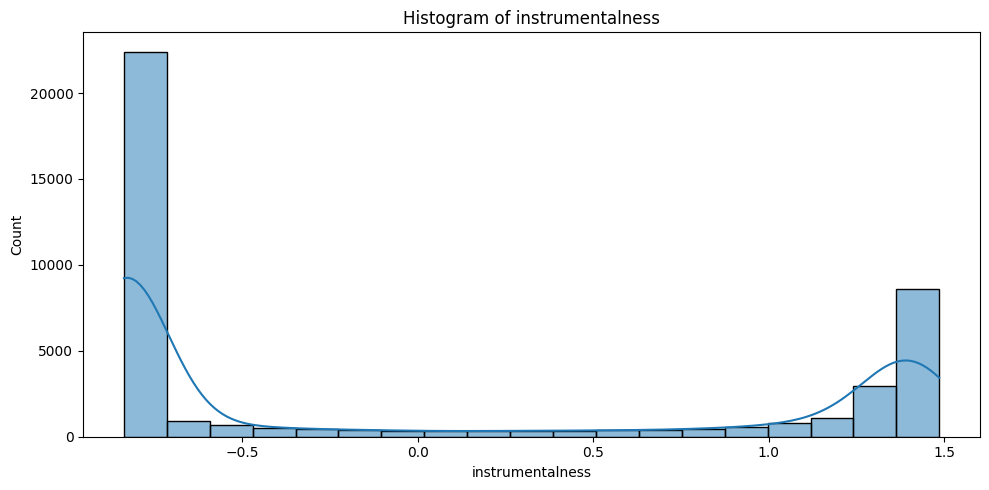

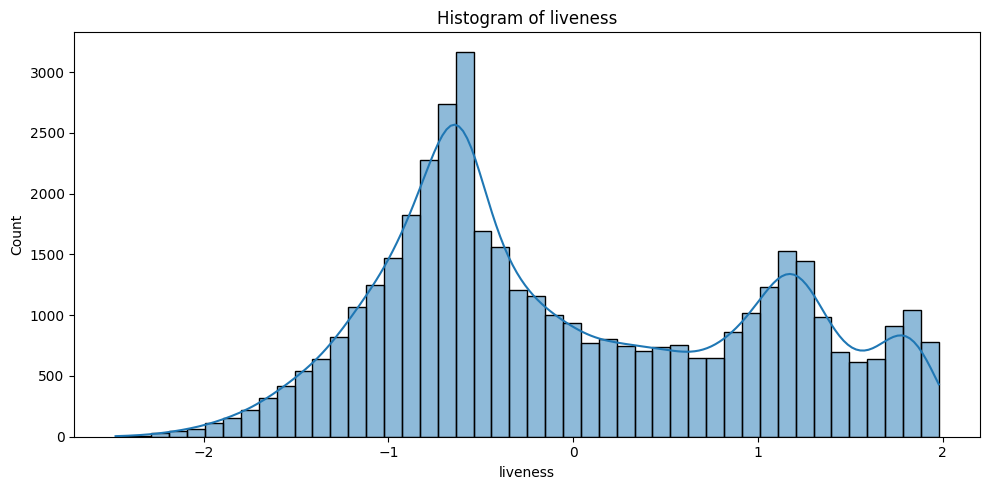

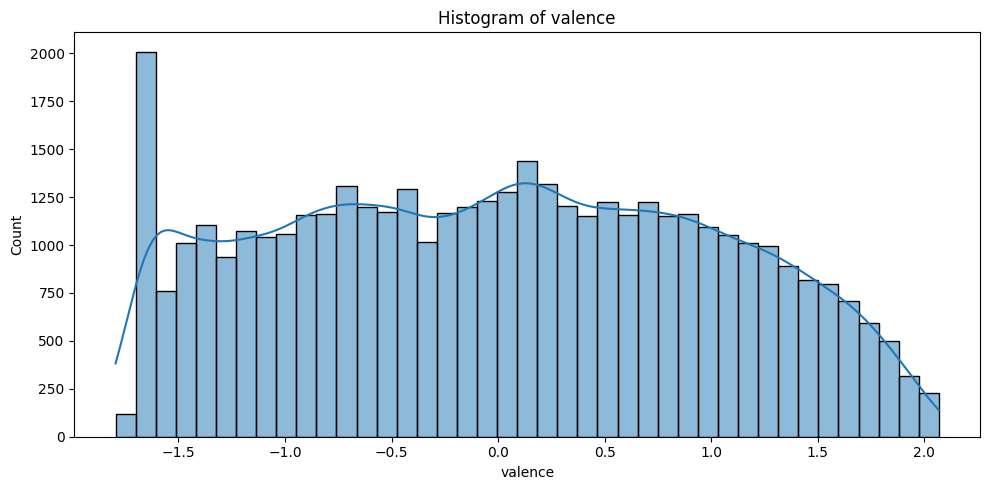

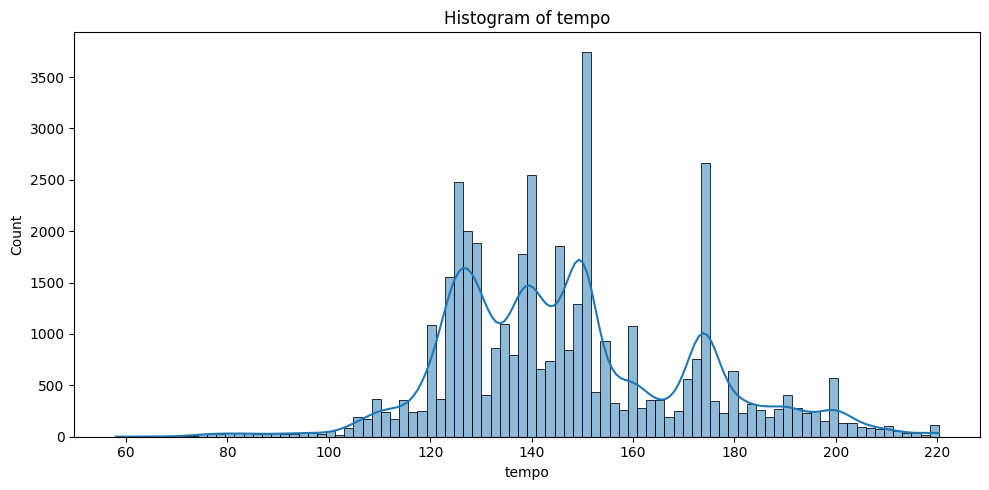

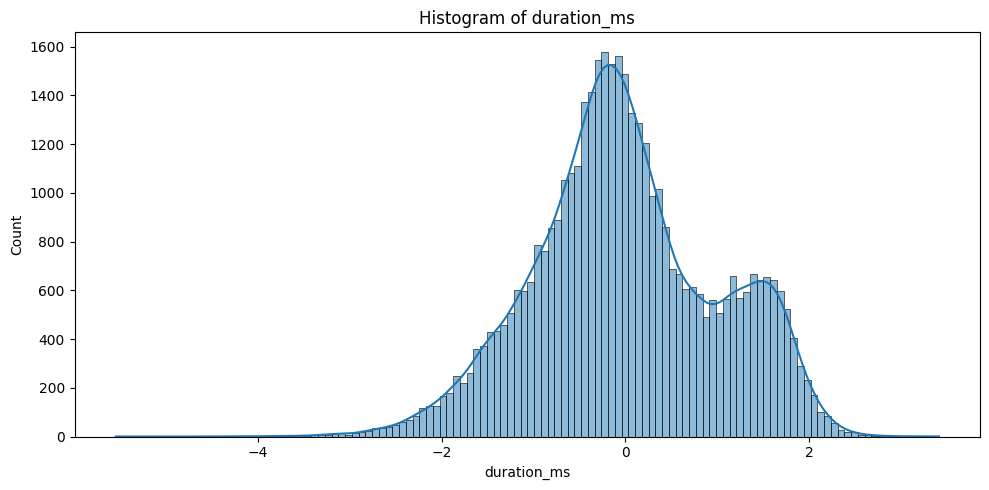

In [10]:
data_analyzer.visualize_numeric_columns(type="histo", unique_value_threshhold=0)

After power transforming the features. We can clearly see two peaks pattern for liveness, instrumentalness, acousticness and mode.
We will use Otsu threshhold to maximize the variance between classes.

In [11]:
data_analyzer.otsu_thresholding(cols=['liveness','instrumentalness','acousticness','mode'])


Lets visualize the numeric columns as boxplots to analyze it further

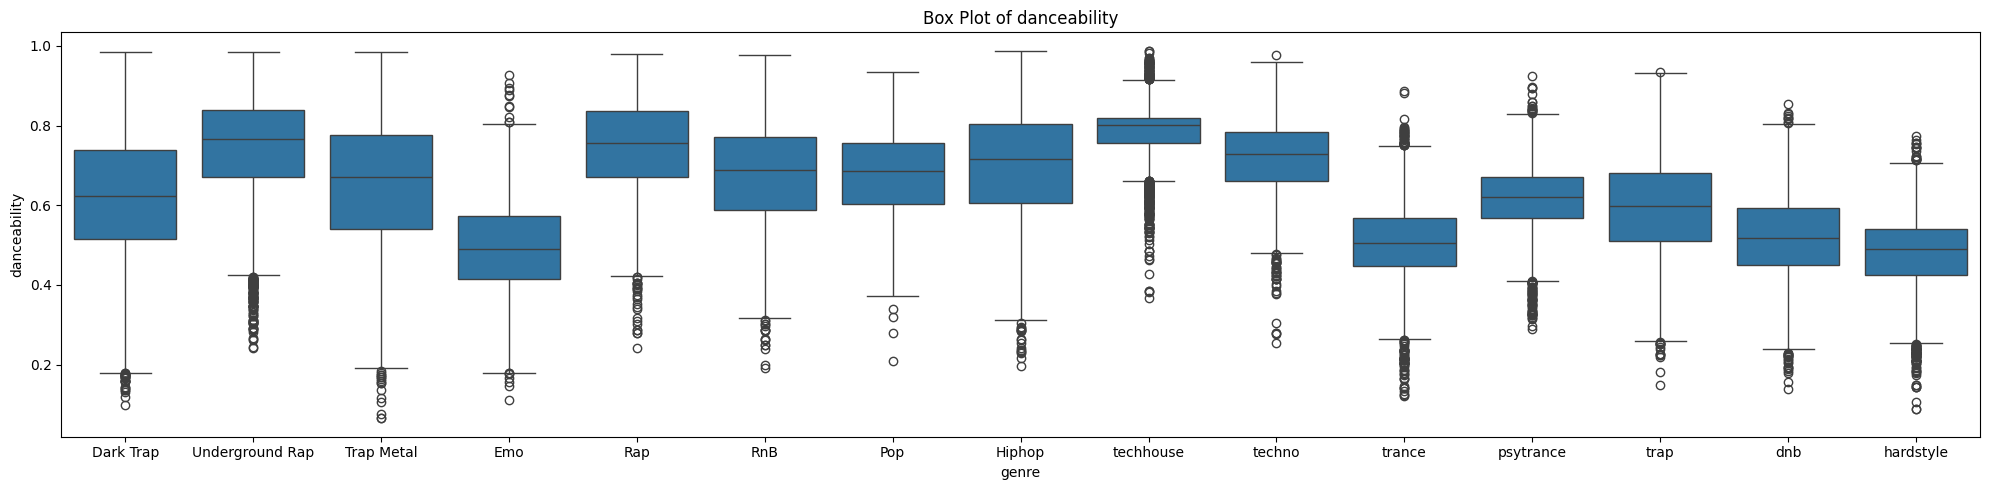

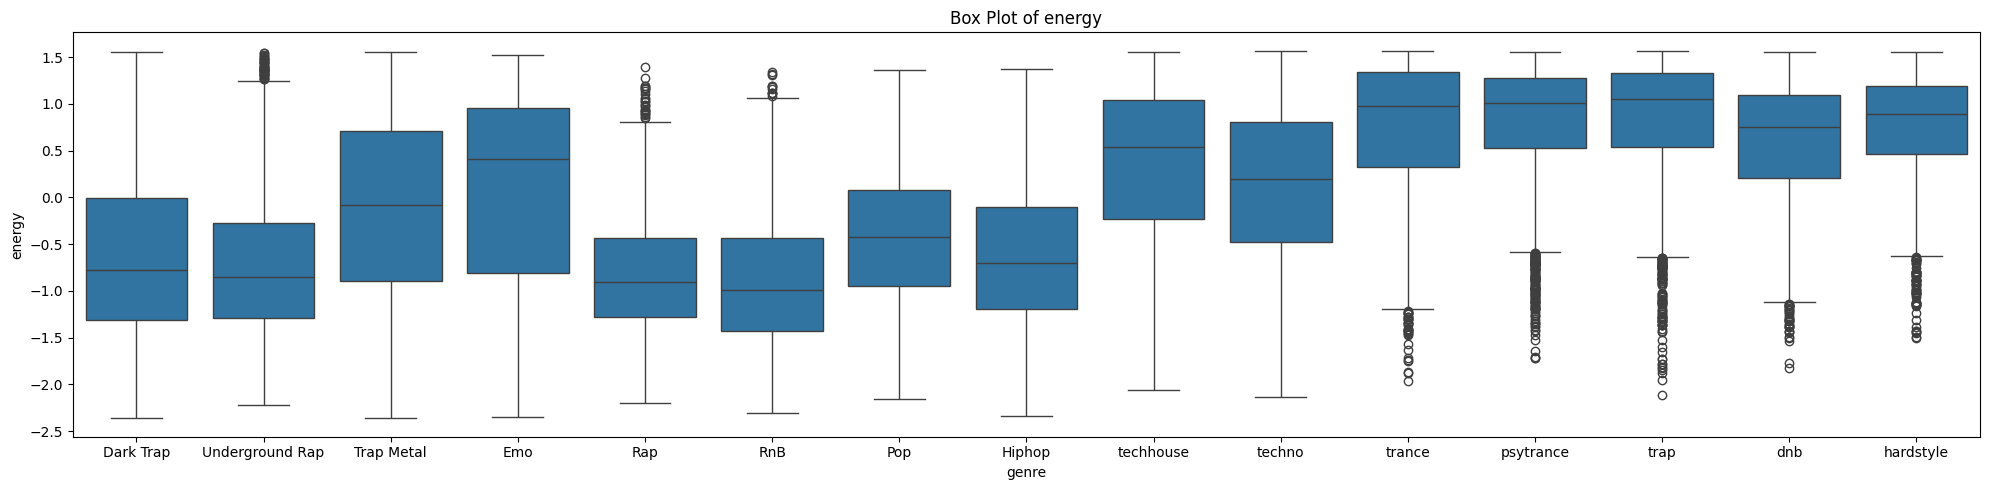

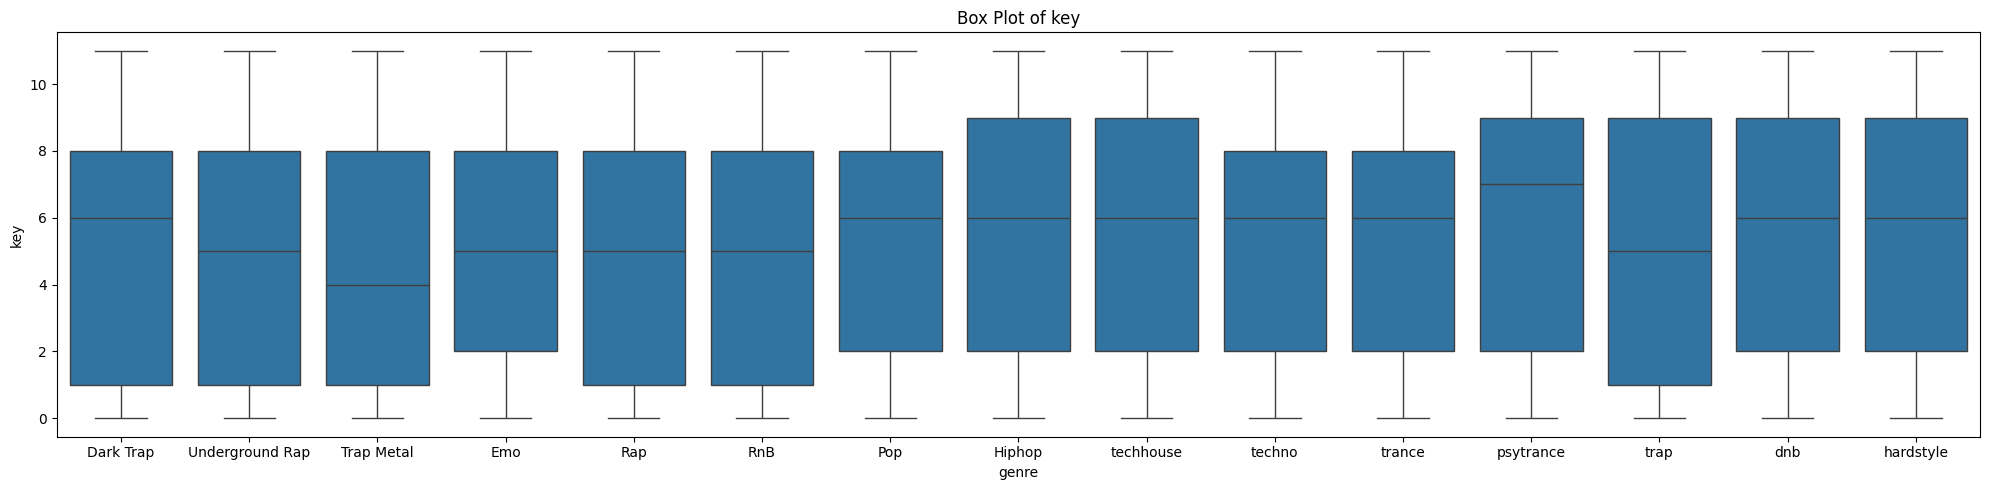

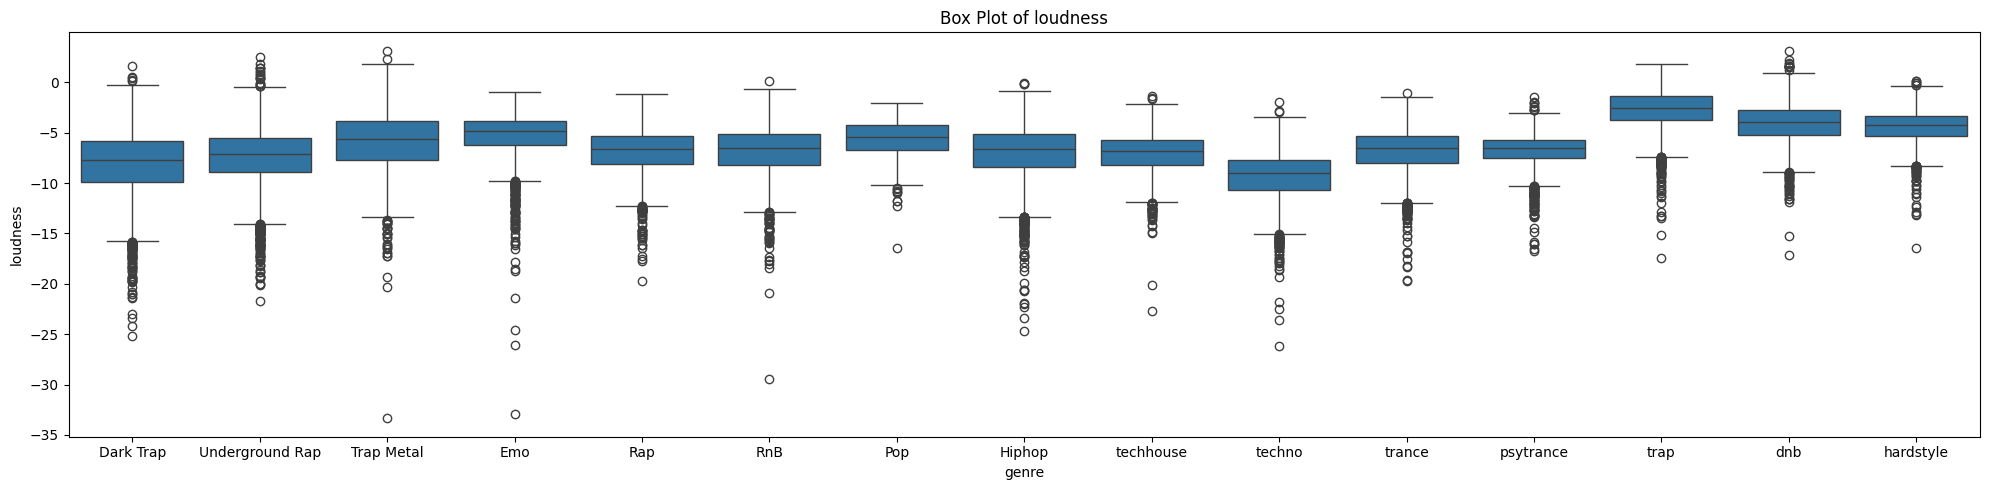

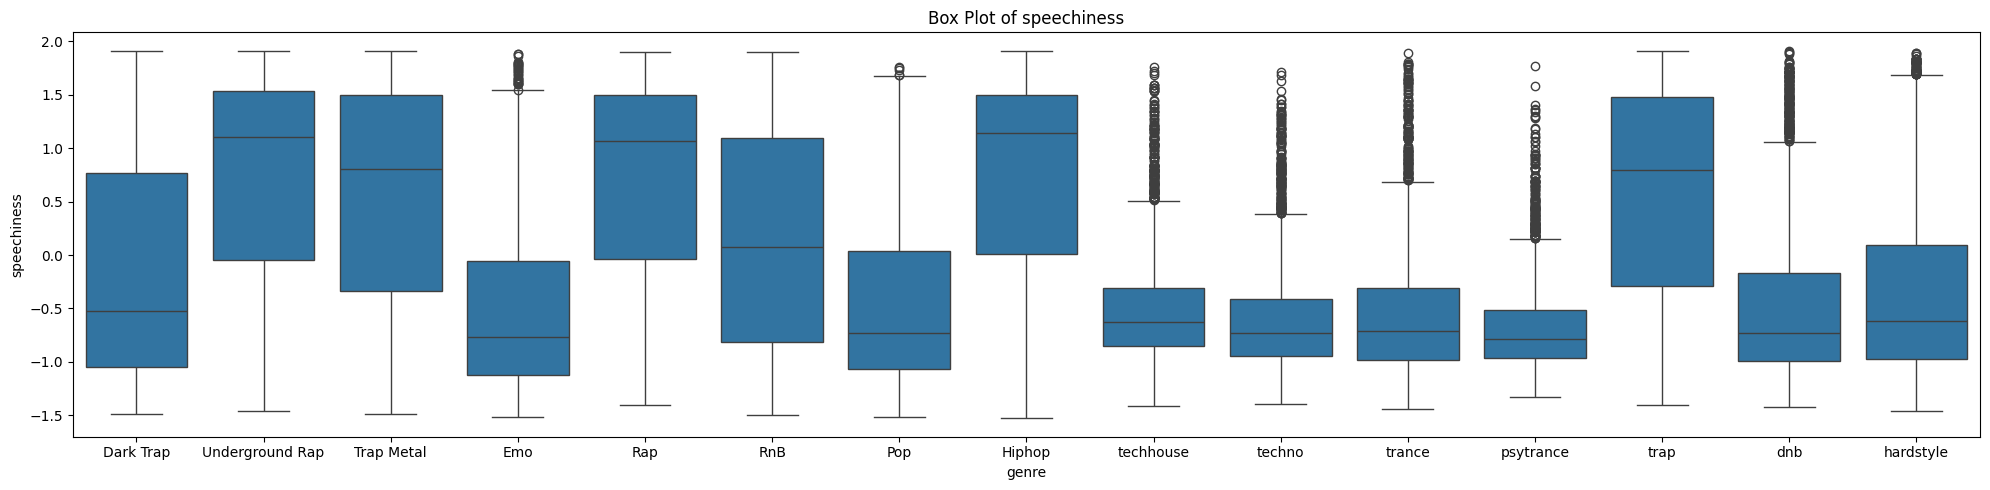

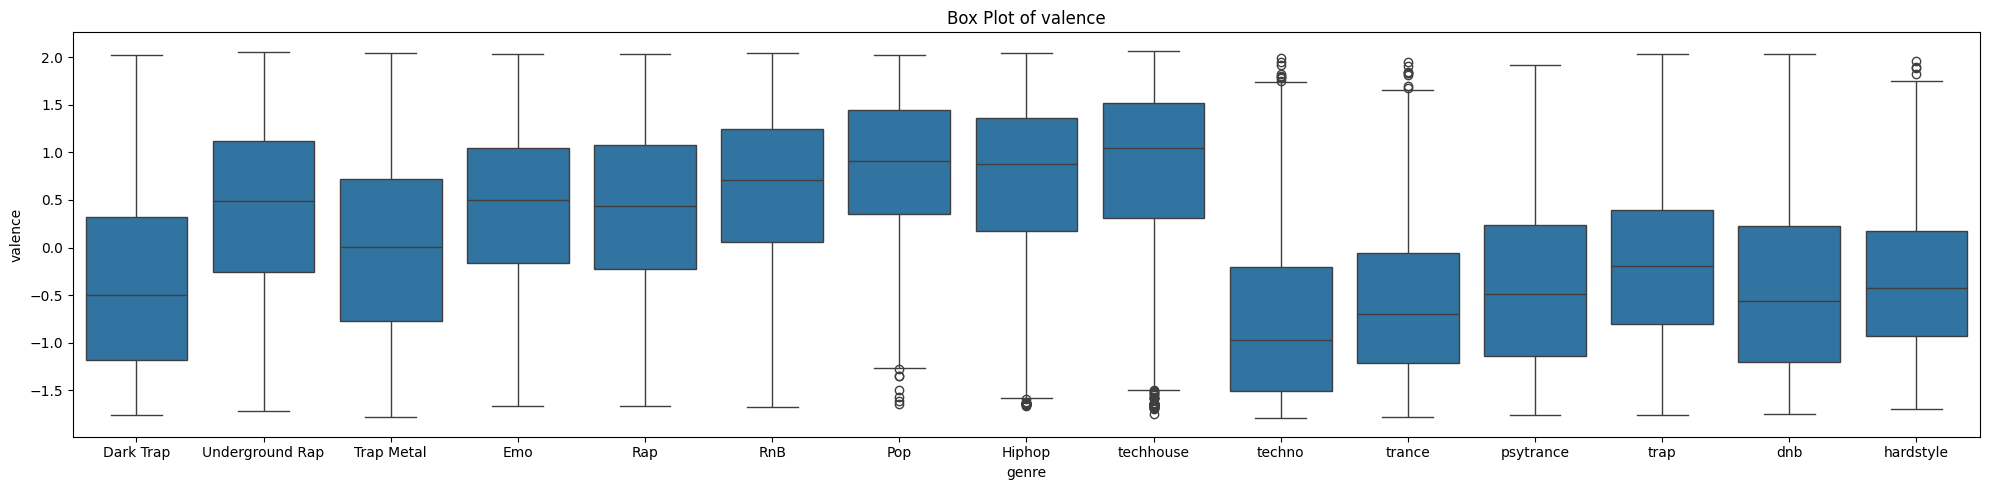

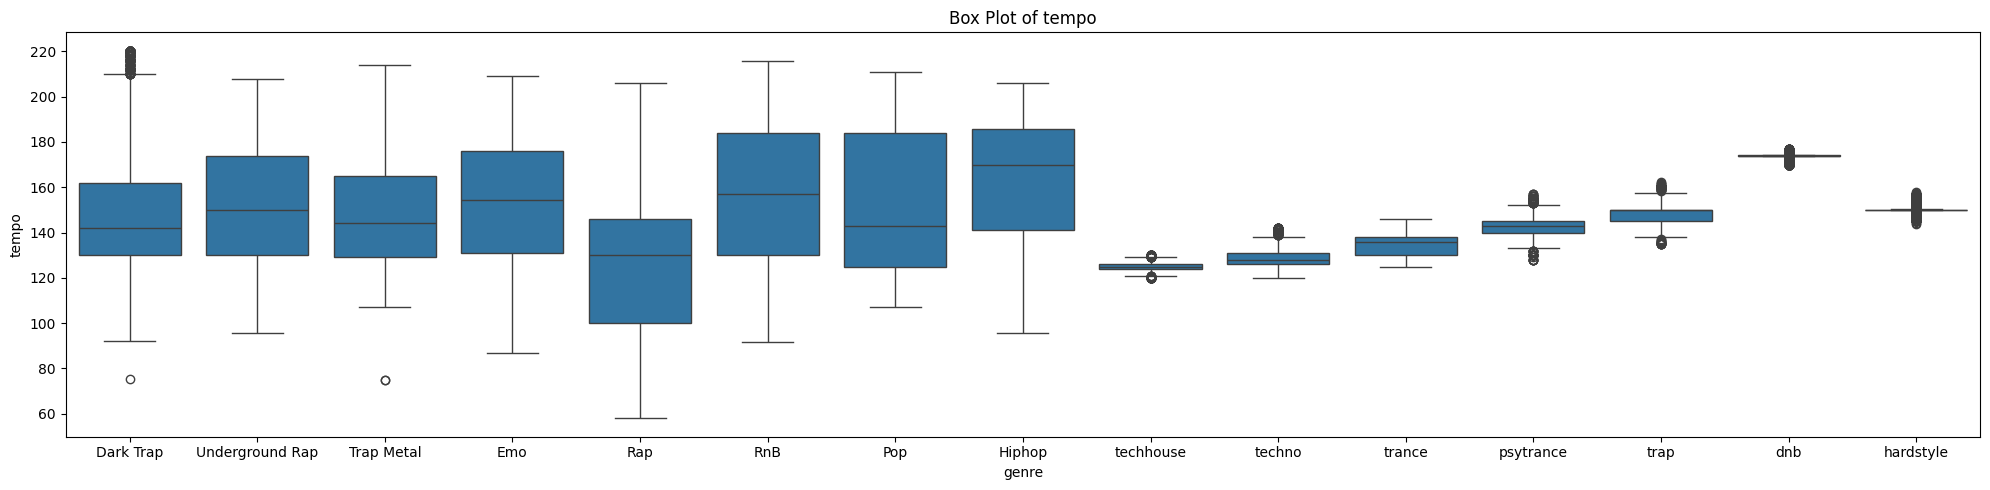

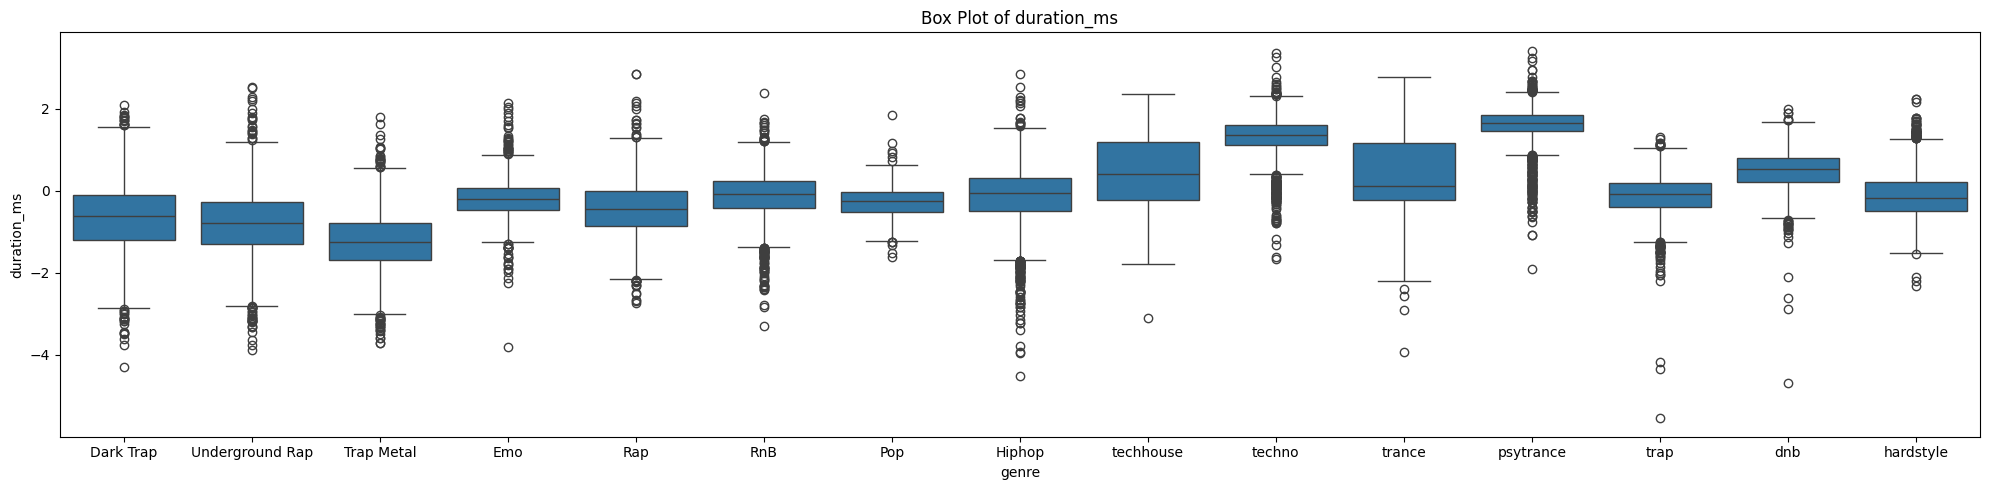

In [12]:
data_analyzer.visualize_numeric_columns(ylabel="genre", size=(20, 5), type="box")

It seems from the boxplot we can see that loudness has every genre looks almost identical boxplot. This indicates that loudness show little to no signal to indicate genres hence its safe to drop.

We can see that many values are ploted outside our boxplots. I did not want to remove these outliers as nothing indicated they are falsely recorded or extreme compared to the rest.

There are also many outliers that are placed outside of the boxplot

In [13]:
data_analyzer.drop_features(['loudness'])

Our goal is to cluster genres based on features. For this we will check correlation features
Because the label is column "Genre" we will not see any feature importance in the correlation heatmap.
However we can still look for redundancy

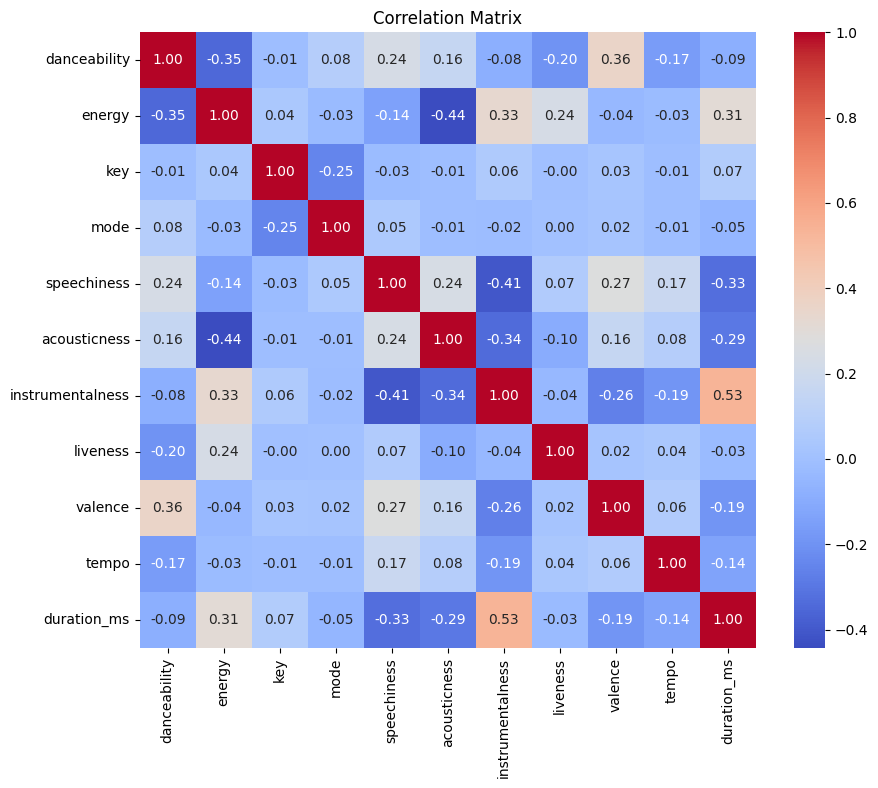

In [14]:
data_analyzer.visualize_correlation_numeric(size=(10,8))

It seems non of the numeric features correlate 80%+ which means each features is unique and has its own importance. 

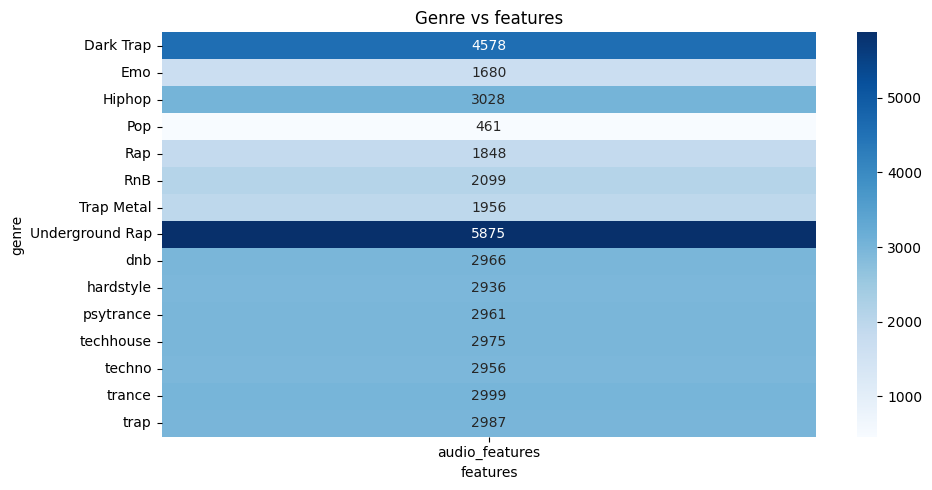

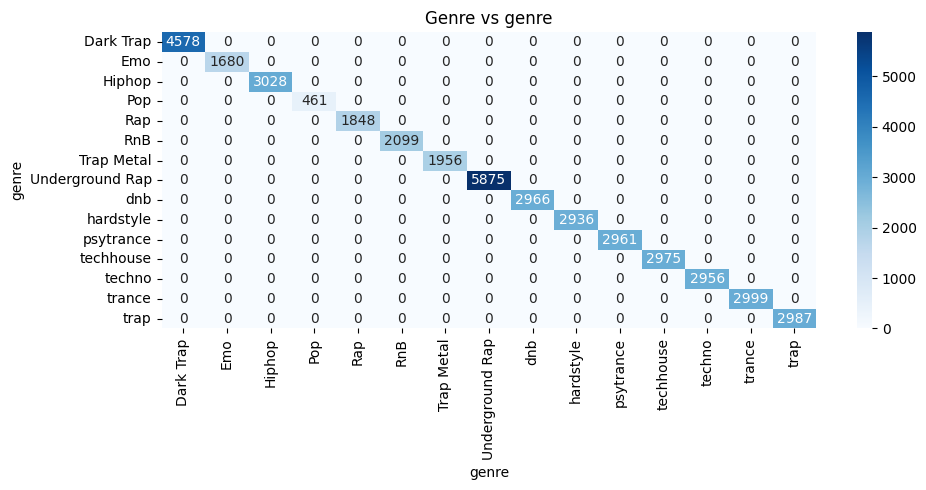

In [15]:
data_analyzer.visualize_correlation_categorical(ylabel="genre")

There is only a single feature in feature column, so let's drop this. 
We will now do some statistical analysis on the remaining features to further analyse which features are important

### Statistical Analysis

In [16]:
data_analyzer.drop_features(['features'])
for col in data_analyzer._df.columns:
    result = data_analyzer.anova_test(ylabel='genre', col=col)
    if result == None:
        continue
    print(f"ANOVA p-value for {col}: ", result[1])


ANOVA p-value for danceability:  0.0
ANOVA p-value for energy:  0.0
ANOVA p-value for key:  1.3511003536121718e-73
ANOVA p-value for mode:  1.0600333220911402e-258
ANOVA p-value for speechiness:  0.0
ANOVA p-value for acousticness:  0.0
ANOVA p-value for instrumentalness:  0.0
ANOVA p-value for liveness:  0.0
ANOVA p-value for valence:  0.0
ANOVA p-value for tempo:  0.0
ANOVA p-value for duration_ms:  0.0


because there is 40k + samples even a slight change in data shows significance hence why every ANOVA value is low.

In [17]:
data_analyzer.mutual_info(ylabel='genre')

mutal info danceability: 0.333
mutal info energy: 0.300
mutal info key: 0.029
mutal info mode: 0.011
mutal info speechiness: 0.245
mutal info acousticness: 0.149
mutal info instrumentalness: 0.320
mutal info liveness: 0.041
mutal info valence: 0.198
mutal info tempo: 1.104
mutal info duration_ms: 0.695


Here we can see that key and mode and near to 0 importance in predicting genre.
So we will drop these.

We will remove every feature that has MI score of 0.3 or less

Let's draw a pair plot showing cluster points

<Figure size 1500x1500 with 0 Axes>

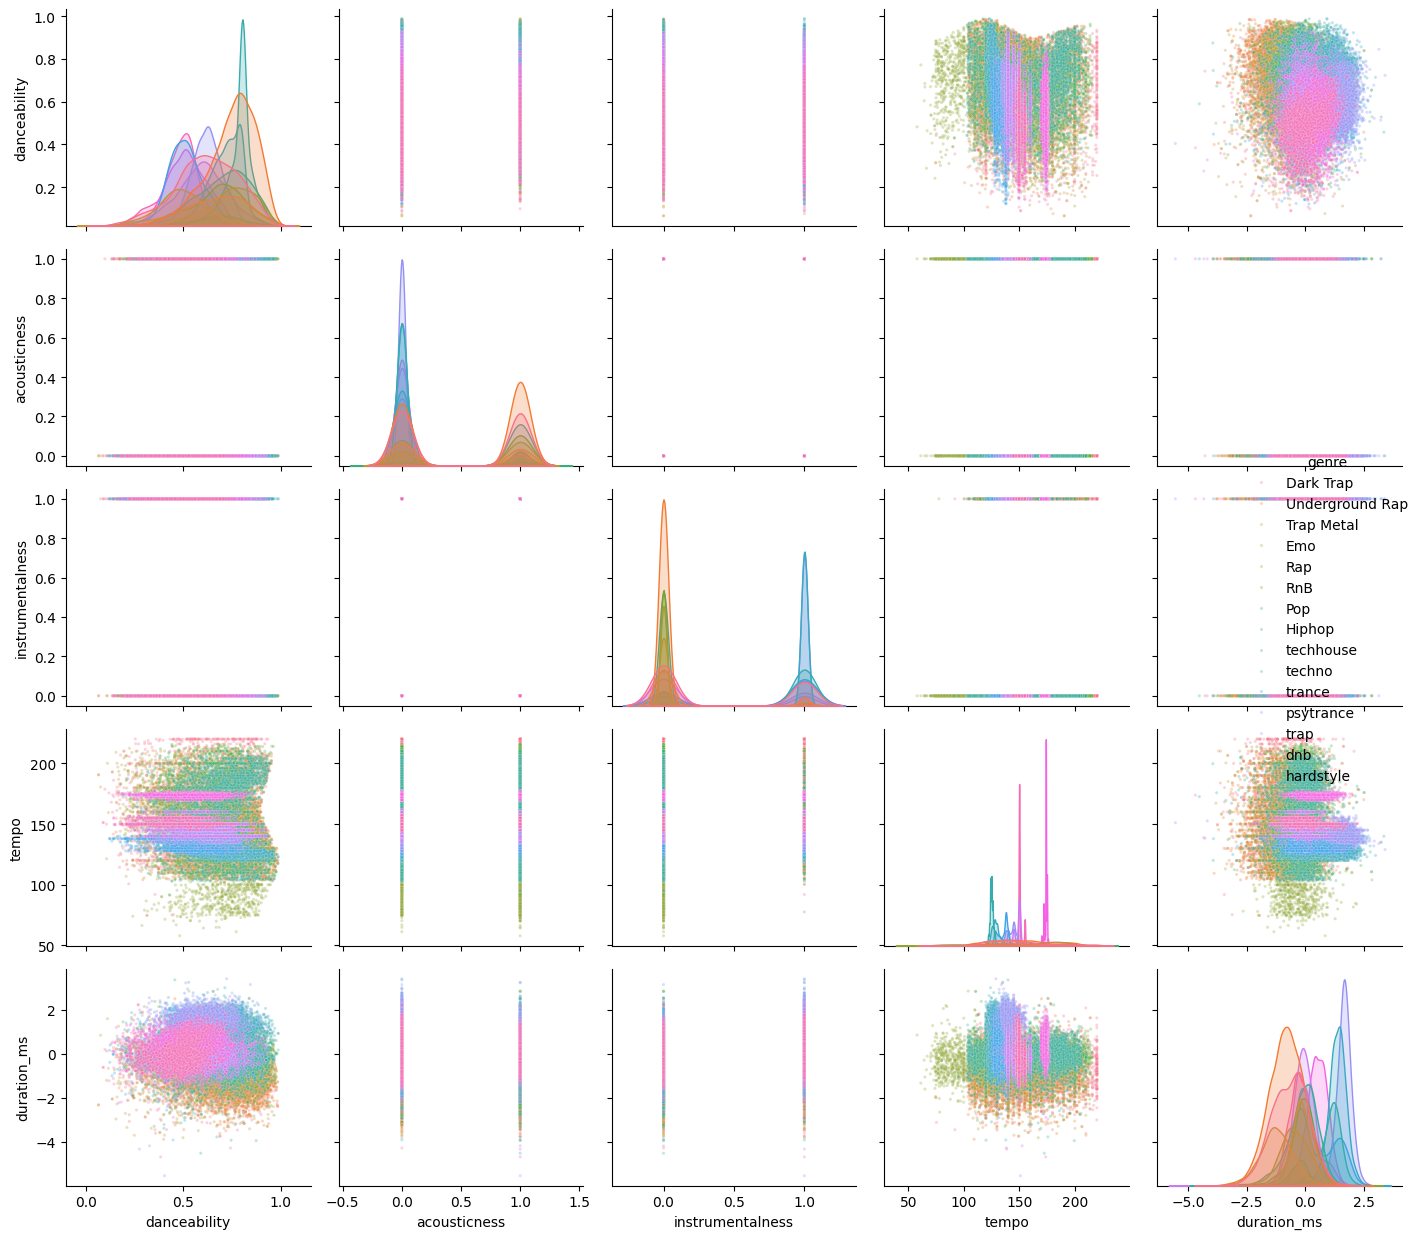

In [18]:
data_analyzer.drop_features(['key', 'mode','energy', 'liveness', 'speechiness','valence'])
data_analyzer._graph_maker(type="pair", ylabel="genre", size=(15,15))

### Preprocessing X and y

Let's check for imbalance in our data

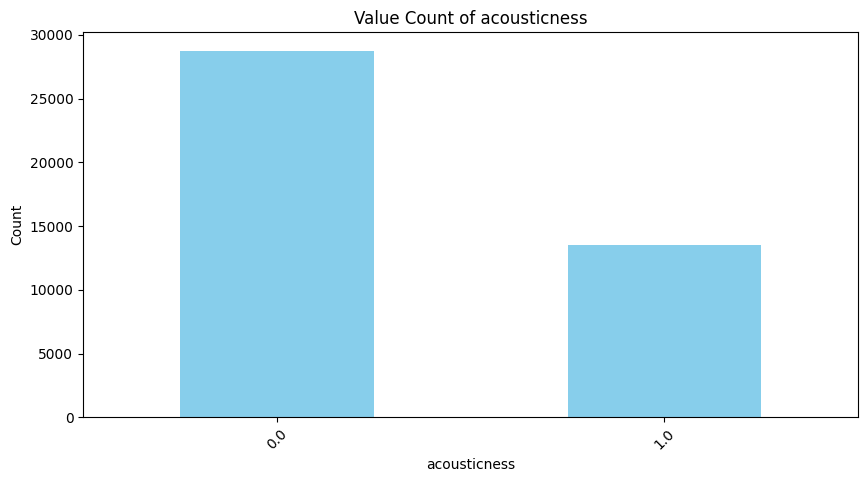

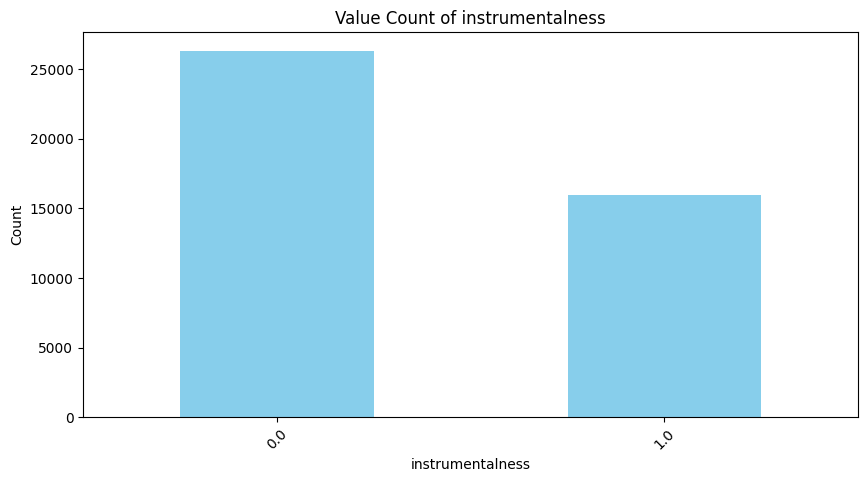

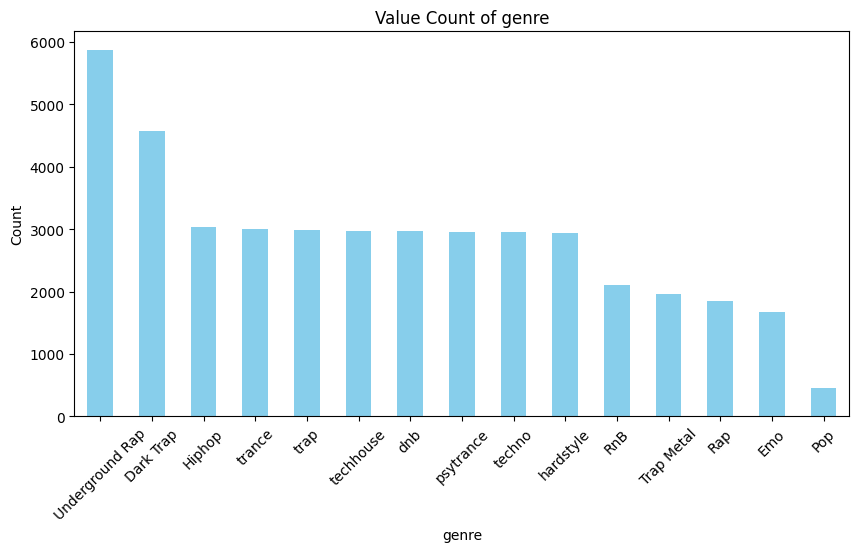

In [19]:
data_analyzer.visualize_column_value_counts()

Since we are using Kmeans classifier no need to resample the imbalance in dataset.
Let's now grab the edited dataframe and separate them into X and y.

In [20]:
modified_df = data_analyzer.get_df()
print(modified_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42305 entries, 0 to 42304
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      42305 non-null  float64
 1   acousticness      42305 non-null  float64
 2   instrumentalness  42305 non-null  float64
 3   tempo             42305 non-null  float64
 4   duration_ms       42305 non-null  float64
 5   genre             42305 non-null  object 
dtypes: float64(5), object(1)
memory usage: 1.9+ MB
None


In [21]:
y = modified_df['genre']
X = modified_df.drop(columns=['genre'])

X.head()

,danceability,acousticness,instrumentalness,tempo,duration_ms
0,0.831,0.0,0.0,156.985,-1.552470
1,0.719,1.0,0.0,115.080,-0.077236
2,0.850,0.0,0.0,218.050,-2.133616
3,0.476,0.0,0.0,186.948,-1.570231
4,0.798,1.0,0.0,147.988,-1.577611


In [22]:
y.head()

0    Dark Trap
1    Dark Trap
2    Dark Trap
3    Dark Trap
4    Dark Trap
Name: genre, dtype: object

Kmeans is a distance based model, therefore we need to standarize the X otherwise features like tempo will show dominance.

Before we saw that boxplot showed lots of outliers in each feature.
So we will use RobustScaler as it is built to handle outliers.

In [23]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

print(X_scaled.shape)

(42305, 5)


The shape matches the df.info()!
Let's now use the elbow method to figure out the best K value


### ELBOW/ SILHOUETTE to check best K

In [24]:
from sklearn.cluster import KMeans

k: 1 inertia: 86557.00040886189 difference from prev: N/A
k: 2 inertia: 64316.490952775115 difference from prev: -22240.509456086773
k: 3 inertia: 50599.474105464695 difference from prev: -13717.01684731042
k: 4 inertia: 41398.42910240237 difference from prev: -9201.045003062325
k: 5 inertia: 37848.45384171553 difference from prev: -3549.9752606868424
k: 6 inertia: 34672.40473384758 difference from prev: -3176.049107867948
k: 7 inertia: 32208.5194998085 difference from prev: -2463.8852340390804
k: 8 inertia: 30036.66458406016 difference from prev: -2171.8549157483394
k: 9 inertia: 28255.091113265487 difference from prev: -1781.5734707946722
k: 10 inertia: 26610.12274011766 difference from prev: -1644.968373147829
k: 11 inertia: 25339.633953660225 difference from prev: -1270.488786457434
k: 12 inertia: 24242.47224258177 difference from prev: -1097.1617110784537
k: 13 inertia: 23211.626295693597 difference from prev: -1030.8459468881738
k: 14 inertia: 22236.69780763292 difference from pr

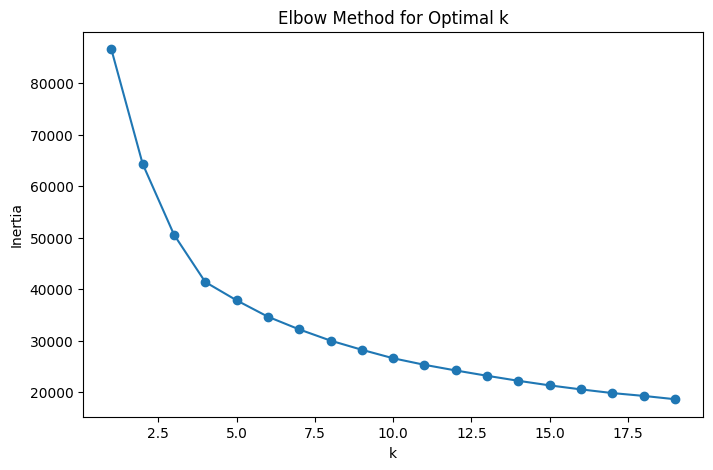

In [25]:
inertias = []
K = range(1, 20)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=20)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    print(f"k: {k} inertia: {kmeans.inertia_} difference from prev: {kmeans.inertia_ - inertias[-2] if k > 1 else 'N/A'}")

plt.figure(figsize=(8,5))
plt.plot(K, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

k 3~5 seems to be a good point for elbow but there is no clear 'elbow' for my graph.
So let's try the silhouette method.

k=2, silhouette=0.246
k=3, silhouette=0.254
k=4, silhouette=0.275
k=5, silhouette=0.263
k=6, silhouette=0.255
k=7, silhouette=0.262
k=8, silhouette=0.265
k=9, silhouette=0.274
k=10, silhouette=0.253
k=11, silhouette=0.261
k=12, silhouette=0.262
k=13, silhouette=0.266
k=14, silhouette=0.267
k=15, silhouette=0.271


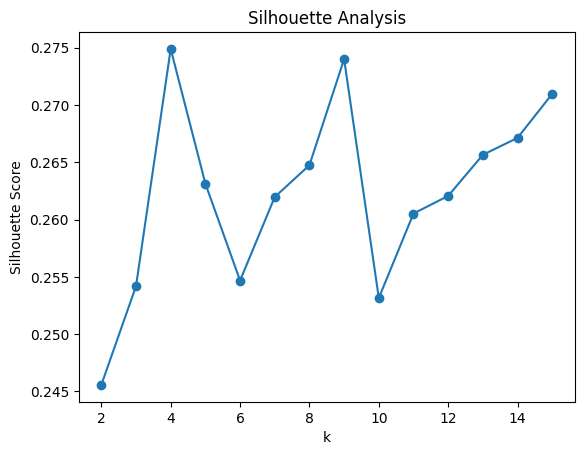

In [26]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

scores = []
for k in range(2, 16):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=20)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores.append(score)
    print(f"k={k}, silhouette={score:.3f}")

plt.plot(range(2, 16), scores, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.show()

It seems that silhouette 4 has the highest score.

Let's now check how the clutered are formed for various clusters

K2 because it showed the highest inertia drop

K4 because it shows highest silhouette score and elbow method

k9 because it shows second highest silhouette

K15 because it is our goal for genre classification and 3rd highest.


### Evaluating our best K

Text(0.5, 1.0, 'k = 15 Crosstab')

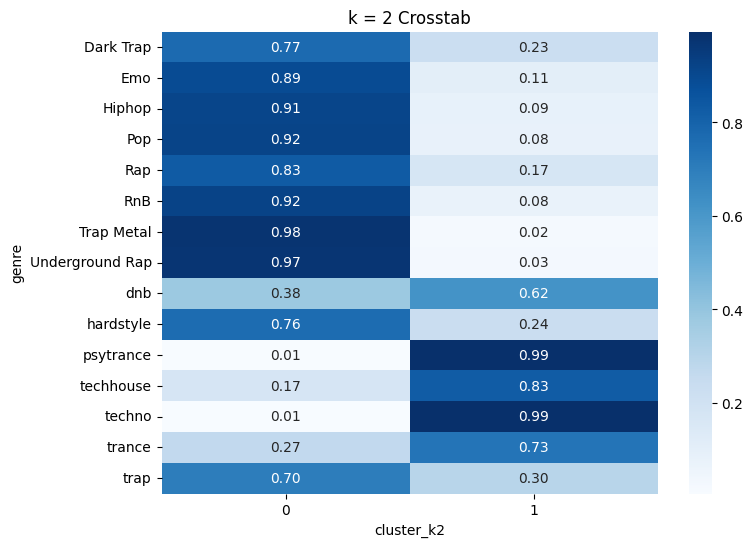

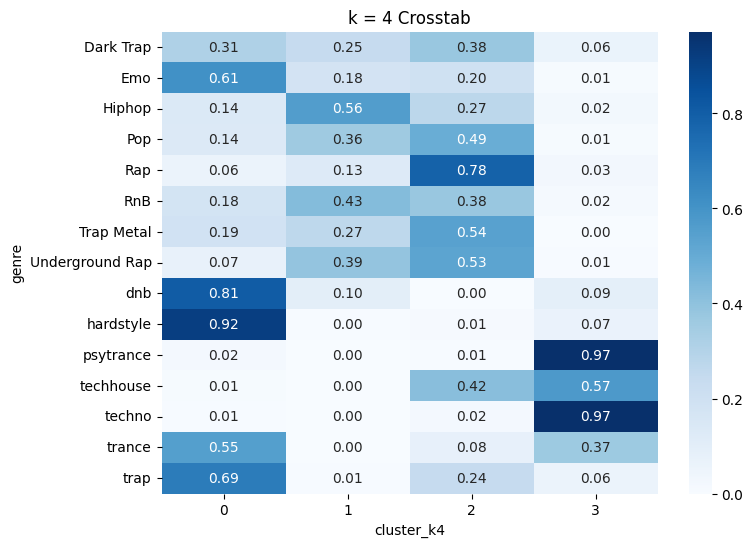

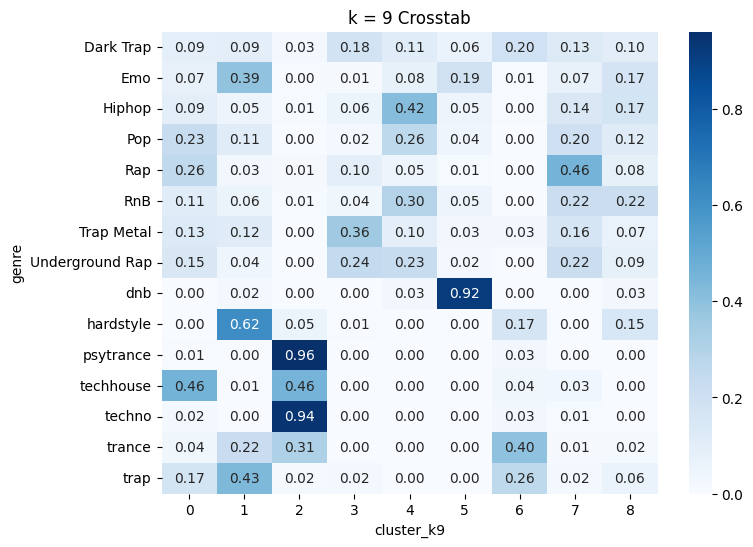

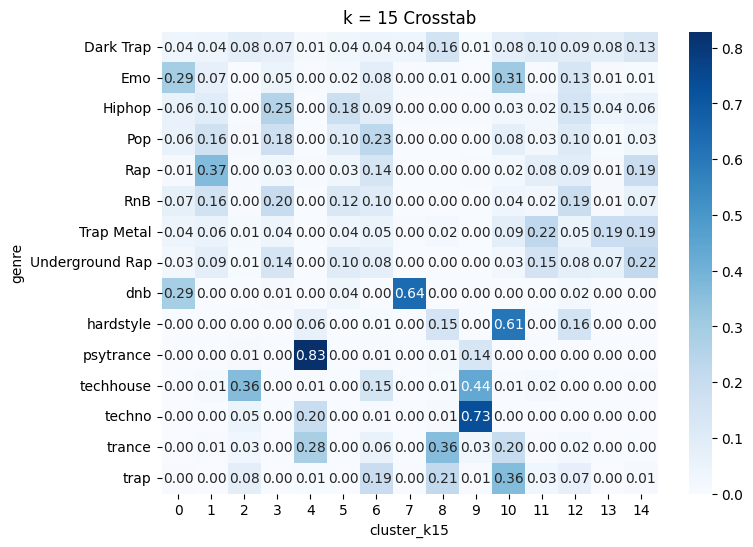

In [27]:
kmeans_k2 = KMeans(n_clusters=2, random_state=0, n_init=20)
modified_df["cluster_k2"] = kmeans_k2.fit_predict(X_scaled)
plt.figure(figsize=(8, 6))
normalized_ct2 = pd.crosstab(y, modified_df["cluster_k2"], normalize='index')
sns.heatmap(normalized_ct2, annot=True, fmt=".2f", cmap="Blues")
plt.title("k = 2 Crosstab")

kmeans_k4 = KMeans(n_clusters=4, random_state=0, n_init=20)
modified_df["cluster_k4"] = kmeans_k4.fit_predict(X_scaled)
plt.figure(figsize=(8, 6))
normalized_ct4 = pd.crosstab(y, modified_df["cluster_k4"], normalize='index')
sns.heatmap(normalized_ct4, annot=True, fmt=".2f", cmap="Blues")
plt.title("k = 4 Crosstab")

kmeans_k9 = KMeans(n_clusters=9, random_state=0, n_init=20)
modified_df["cluster_k9"] = kmeans_k9.fit_predict(X_scaled)
plt.figure(figsize=(8, 6))
normalized_ct9 = pd.crosstab(y, modified_df["cluster_k9"], normalize='index')
sns.heatmap(normalized_ct9, annot=True, fmt=".2f", cmap="Blues")
plt.title("k = 9 Crosstab")

kmeans_k15 = KMeans(n_clusters=15, random_state=0, n_init=20)
modified_df["cluster_k15"] = kmeans_k15.fit_predict(X_scaled)
plt.figure(figsize=(8, 6))
normalized_ct15 = pd.crosstab(y, modified_df["cluster_k15"], normalize='index')
sns.heatmap(normalized_ct15, annot=True, fmt=".2f", cmap="Blues")
plt.title("k = 15 Crosstab")


It seems the k2 is grouping instrumental music vs non-instrumental music.
And we can clearly see each k iteration having distinct genre representing it.
However Dark Trap is showing least dominant showing equaly amongst almost all clusters. as the K increases.
Now let us evaluate the result models.

### Evaluation

In [28]:
cluster_labels_k2 = normalized_ct2.idxmax(axis=1)
cluster_labels_list_k2 = cluster_labels_k2.groupby(cluster_labels_k2).apply(lambda x: x.index.tolist()).to_dict()
cluster_labels_k4 = normalized_ct4.idxmax(axis=1)
cluster_labels_list_k4 = cluster_labels_k4.groupby(cluster_labels_k4).apply(lambda x: x.index.tolist()).to_dict()
cluster_labels_k9 = normalized_ct9.idxmax(axis=1)
cluster_labels_list_k9 = cluster_labels_k9.groupby(cluster_labels_k9).apply(lambda x: x.index.tolist()).to_dict()
cluster_labels_k15 = normalized_ct15.idxmax(axis=1)
cluster_labels_list_k15 = cluster_labels_k15.groupby(cluster_labels_k15).apply(lambda x: x.index.tolist()).to_dict()

modified_df['genre'] = y

def evaluator(target_label, predicted_label, cluster_label):
    score = 0
    for g,t in zip(target_label, predicted_label):
        if cluster_label[g] == t:
            score += 1
    print(f"correct: {score}")
    print(score / (target_label.shape[0]) * 100)

print("k = 2")
print(cluster_labels_list_k2)
evaluator(modified_df['genre'], modified_df['cluster_k2'], cluster_labels_k2)
print("k = 4")
print(cluster_labels_list_k4)
evaluator(modified_df['genre'], modified_df['cluster_k4'], cluster_labels_k4)
print("k = 9")
print(cluster_labels_list_k9)
evaluator(modified_df['genre'], modified_df['cluster_k9'], cluster_labels_k9)
print("k = 15")
print(cluster_labels_list_k15)
evaluator(modified_df['genre'], modified_df['cluster_k15'], cluster_labels_k15)

k = 2
{0: ['Dark Trap', 'Emo', 'Hiphop', 'Pop', 'Rap', 'RnB', 'Trap Metal', 'Underground Rap', 'hardstyle', 'trap'], 1: ['dnb', 'psytrance', 'techhouse', 'techno', 'trance']}
correct: 36033
85.17432927549935
k = 4
{0: ['Emo', 'dnb', 'hardstyle', 'trance', 'trap'], 1: ['Hiphop', 'RnB'], 2: ['Dark Trap', 'Pop', 'Rap', 'Trap Metal', 'Underground Rap'], 3: ['psytrance', 'techhouse', 'techno']}
correct: 27453
64.89303864791395
k = 9
{0: ['techhouse'], 1: ['Emo', 'hardstyle', 'trap'], 2: ['psytrance', 'techno'], 3: ['Trap Metal', 'Underground Rap'], 4: ['Hiphop', 'Pop', 'RnB'], 5: ['dnb'], 6: ['Dark Trap', 'trance'], 7: ['Rap']}
correct: 20575
48.6349131308356
k = 15
{1: ['Rap'], 3: ['Hiphop', 'RnB'], 4: ['psytrance'], 6: ['Pop'], 7: ['dnb'], 8: ['Dark Trap', 'trance'], 9: ['techhouse', 'techno'], 10: ['Emo', 'hardstyle', 'trap'], 11: ['Trap Metal'], 14: ['Underground Rap']}
correct: 16715
39.510696135208605


It looks like the model does decent job showing 40% accuracy at k=15 which is significantly greater than 6.667% you'd get when randomly guessing which genre the music belongs to. The accuracy seems to drop as k value increases but this is as expected. k4 is showing almost 65% accuracy identifying into 4 catergories. This is interesting because most of the genre in each of the groups can be categorized as its subgenres. It seems that cluster 0 in the k = 15 version shows no dominant genre.
Overall k = 4 shows the best result and coherent classification based on the dataset given.

Let's calculate the purity

In [31]:
contingency = pd.crosstab(modified_df['genre'], modified_df['cluster_k4'])
purity = contingency.max(axis=1) / contingency.sum(axis=1)
print(purity)

genre
Dark Trap          0.377894
Emo                0.608929
Hiphop             0.561096
Pop                0.490239
Rap                0.784632
RnB                0.428299
Trap Metal         0.541922
Underground Rap    0.528681
dnb                0.805125
hardstyle          0.917575
psytrance          0.971969
techhouse          0.573782
techno             0.971922
trance             0.554185
trap               0.688986
dtype: float64


as mentioned above silhouette score is 

k=4, silhouette=0.275 which means there is moderate amount of clustering happening.

It seems that most of my genres are classified into a single cluster.

only pop,darktrap,rnb showing less than 50% purity while rest are all above some reaching almost 100%.

### Visualize the result

We will reduce the features down to 2D for plotting.

We will use PCA for this.

<Axes: xlabel='pca1', ylabel='pca2'>

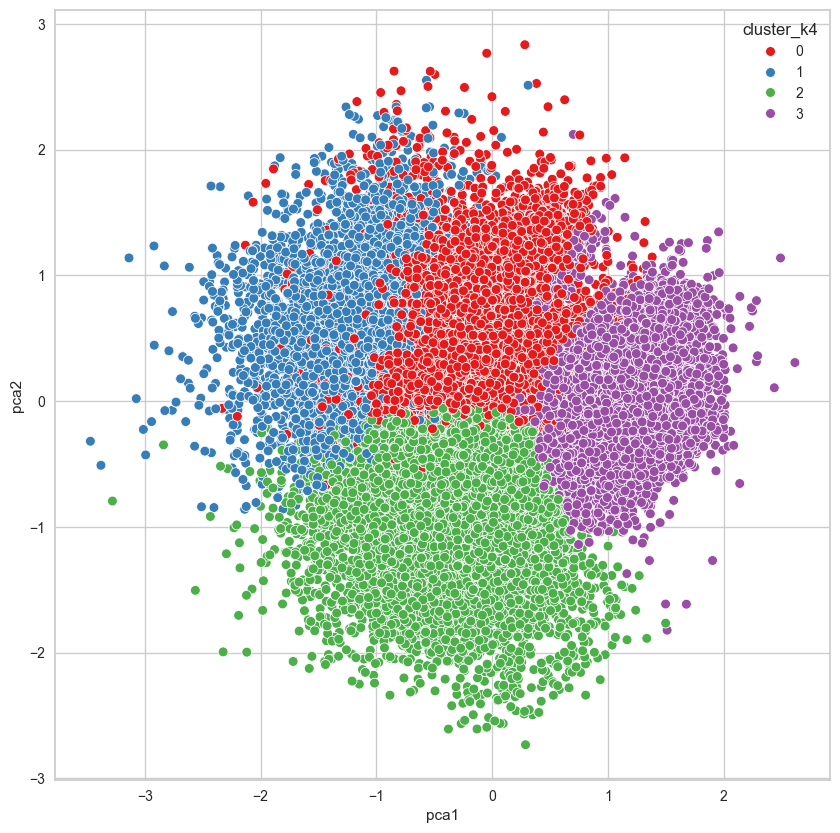

In [87]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

modified_df['pca1'] = X_pca[:, 0]  
modified_df['pca2'] = X_pca[:, 1]


plt.figure(figsize=(10,10))
sns.scatterplot(x='pca1', y='pca2', hue='cluster_k4', data=modified_df, palette='Set1', alpha=1, s=50, legend="auto")


Clear 4 clusters are shown on the graph

<Axes: xlabel='pca1', ylabel='pca2'>

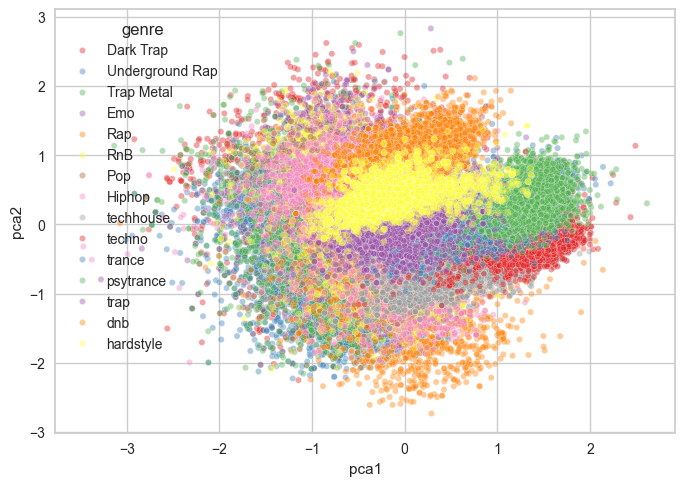

In [88]:
sns.scatterplot(x='pca1', y='pca2', hue='genre', data=modified_df, palette='Set1', alpha=.4, s=20, markers='x', legend='auto')

The original dataset does not show clear 15 genres.